This notebook illustrates the main features of the Community Simulator package. 

# The Model

The Community Simulator is an open-ended platform, which can incorporate any ODE model based on concentrations of consumers and resources. The only model currently implemented is the MacArthur Consumer Resource Model (CRM). In this model, the populations $N_i$ of $S$ distinct species and the concentrations $R_\alpha$ of $M$ distinct resources evolve according to the following ODE's:

\begin{align}
\frac{dN_i}{dt} &= N_i\left[ \sum_\beta c_{i\beta}w_\beta - m_i\right]\\
\frac{dR_\alpha}{dt} &= R_\alpha\left[ r_\alpha(1-K_\alpha^{-1}R_\alpha) - \sum_j c_{j\alpha}N_j\right].
\end{align}

For the batch culture experiments this module is designed to simulate, there is no internal source of resource regeneration, and so $r_\alpha$ will always be set to zero for all $\alpha$. This makes $K_\alpha$ irrelevant as well. 

For now, we will measure resource concentrations in units of biomass equivalent, so that $w_\alpha = 1$. The remaining parameters $c_{i\alpha}$ and $m_i$ will be explained in the following sections.

The file `models.py` holds the functions for calculation $dN_i/dt$ and $dR_\alpha/dt$, and will include more complex models (including the Microbial CRM with crossfeeding) in future versions. The functions to be used for modeling a given experiment are loaded into a list, which will be passed as an argument when initializing an instance of the Community class:

In [1]:
from community_simulator.models import dNdt_CRM, dRdt_CRM

dynamics = [dNdt_CRM,dRdt_CRM]

## Load parameters from Excel

Community Simulator is designed to work with Pandas, a powerful data science module that comes pre-installed with the Anaconda Python distribution. We can use Pandas to load in the parameters for our simulation from a Microsoft Excel spreadsheet. 

The Pandas syntax is very straightforward: you just feed the `read_excel` function the filename of the spreadsheet, and (if there are multiple sheets in the workbook) the name of the sheet you want to load. The workbook `test_data.xlsx` included with this distribution contains six sheets, with all the information required to run a simple experiment.

## Consumption Matrix

Let's start by loading the consumption matrix $c_{i\alpha}$, which is the heart of the MacArthur Consumer Resource Model (CRM) and all its variants:

In [2]:
import pandas as pd
c = pd.read_excel('data/test_data.xlsx',sheetname='Consumption')
c

,Glutamine,Citrate,R2,R3,R4,R5,R6,R7,R8
Enterobacter,1.000,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Pseudomonas,0.001,0.990,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Flavobacter,0.480,0.490,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Enterococca,0.490,0.480,0.01,0.01,0.01,0.01,0.01,0.01,0.01


This matrix specifies the per capita consumption rate of each nutrient for each species. The vector of consumption rates is what defines a species for the purposes of the model. I have given the two primary carbon sources realistic names, and also supplied a low level of six "unknown" resources. (Note: These are not meant to be the actual consumption vectors for the four bacterial strains listed here; the only purpose of the names is to make clear that each row represents a distinct strain.)

## Cost Vector

The MacArthur CRM contains another important set of parameters, which are the minimal consumption rates $m_i$ required for survival. For this example, we will set all of them to be equal:

In [3]:
import pandas as pd
m = pd.read_excel('data/test_data.xlsx',sheetname='Cost')
m

,Cost
Enterobacter,0.001
Pseudomonas,0.001
Flavobacter,0.001
Enterococca,0.001


## Initial Conditions

Now let's set the initial cell densities $N_i(0)$ in each wells of our example four-well plate:

In [4]:
N0 = pd.read_excel('data/test_data.xlsx',sheetname='Populations')
N0

,well1,well2,well3,well4
Enterobacter,0.01,0.00,0.01,0
Pseudomonas,0.01,0.00,0.00,0
Flavobacter,0.00,0.01,0.00,0
Enterococca,0.00,0.01,0.00,0


I have kept one well empty for doing a coalescence experiment later on, and one well contains the "champion" from well1. When we perform serial dilution experiments later on, the absolute numbers of individuals will be important. By default, the density is measured in units of $10^9$ cells/well. 

Another sheet lists the initial concentrations of nutrients $R_\alpha(0)$ in each well:

In [5]:
R0 = pd.read_excel('data/test_data.xlsx',sheetname='Resources')
R0

,well1,well2,well3,well4
Glutamine,1.0000,1.0000,1.0000,1.0000
Citrate,1.0000,1.0000,1.0000,1.0000
R2,0.0001,0.0001,0.0001,0.0001
R3,0.0001,0.0001,0.0001,0.0001
R4,0.0001,0.0001,0.0001,0.0001
R5,0.0001,0.0001,0.0001,0.0001
R6,0.0001,0.0001,0.0001,0.0001
R7,0.0001,0.0001,0.0001,0.0001
R8,0.0001,0.0001,0.0001,0.0001


These concentrations will be supplied to these wells every time we passage the cells. 

## Protocol

The feature that really makes this Community Simulator package unique is the built-in passaging functionality. The Passage method takes as an argument a matrix $f$ like this one:

In [6]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheetname='Dilute')
f_dilute

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0.000
well2 new,0.000,0.001,0.000,0.000
well3 new,0.000,0.000,0.001,0.000
well4 new,0.000,0.000,0.000,0.001


The matrix specifies what fraction of each well should be loaded into each of the fresh wells. This is where the absolute number of cells in each well becomes important, because the program always loads an integer number of cells of each species into the new wells, choosing these numbers by multinomial sampling.

This particular matrix is a simple dilution protocol, taking 0.1% of each well and loading it into the corresponding well on the new plate. But we can also make more complicated protocols, like this one for performing a coalescence experiment: 

In [7]:
f_mix = pd.read_excel('data/test_data.xlsx',sheetname='Mix')
f_mix

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0
well2 new,0.000,0.001,0.000,0
well3 new,0.001,0.001,0.000,0
well4 new,0.000,0.001,0.001,0


This performs a standard dilution in wells 1 and 2, but then mixes the contents of wells 1 and 2 in well 3, and mixes the "champion" of well1 with the well2 community in well4. We can also build matrices to simulate diffusion, mixing each well with its neighbors at each step. 

# The Community Class

With all these variables loaded, we can now create an instance of the "Community" class. This instance will contain the current population levels and resource concentrations in each well, and also holds the equations and the parameters that define the model. 

In [8]:
from community_simulator import Community
import numpy as np
from community_simulator.models import dNdt_CRM, dRdt_CRM
import pandas as pd

init_state = [pd.read_excel('data/test_data.xlsx',sheetname='Populations'),
              pd.read_excel('data/test_data.xlsx',sheetname='Resources')]

dynamics = [dNdt_CRM,dRdt_CRM]

params={'c':pd.read_excel('data/test_data.xlsx',sheetname='Consumption'),
        'm':pd.read_excel('data/test_data.xlsx',sheetname='Cost'),
        'r':np.zeros(len(init_state[1])),
        'Kinv':np.ones(len(init_state[1])),
        'w':np.ones(len(init_state[1]))
       }


MyPlate = Community(init_state,dynamics,params,scale=10**9)

"Community" takes three mandatory arguments for initialization: the initial state, the dynamics, and the parameters. There is also an option for adjusting the units of $N_i$, which are set by default to $10^9$/well. We can test whether things are working by following the population of a single well over time:

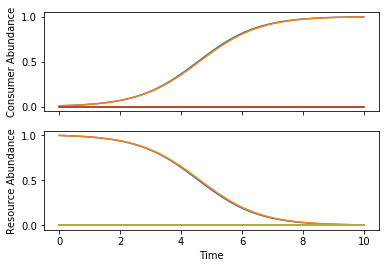

In [9]:
t, Ntraj, Rtraj = MyPlate.TestWell(T=10)

The basic methods of the `Community` class are `Propagate`, which simply runs the model for a fixed amount of time, and `Passage`, which passages the cells to a fresh plate following the protocol matrix $f$ that is passed as an argument.

In [10]:
MyPlate.Propagate(10)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,1.000434,0.00000,1.005891,0.0
Pseudomonas,0.999945,0.00000,0.000000,0.0
Flavobacter,0.000000,0.99901,0.000000,0.0
Enterococca,0.000000,0.99901,0.000000,0.0


In [11]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheetname='Dilute')
MyPlate.Passage(f_dilute)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.001,0.000000,0.001006,0.0
Pseudomonas,0.001,0.000000,0.000000,0.0
Flavobacter,0.000,0.000998,0.000000,0.0
Enterococca,0.000,0.001000,0.000000,0.0


We can automatically run $n$ serial dilutions using protocol $f$ at fixed time intervals $T$ using the `RunExperiment` method:

In [12]:
n = 10
T = 10
MyPlate.Propagate(T)
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.952805,0.000000,0.956077,0.0
Pseudomonas,0.947911,0.000000,0.000000,0.0
Flavobacter,0.000000,0.937268,0.000000,0.0
Enterococca,0.000000,0.935754,0.000000,0.0


Note that `RunExperiment` returns trajectory outputs `Ntraj` and `Rtraj`, which are multiindex dataframes:

In [13]:
Ntraj

Enterobacter  Pseudomonas  Flavobacter  Enterococca
Time Well                                                      
0    well1      0.954782     0.950390     0.000000     0.000000
     well2      0.000000     0.000000     0.939184     0.940989
     well3      0.958222     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
10   well1      0.952851     0.948078     0.000000     0.000000
     well2      0.000000     0.000000     0.936531     0.936923
     well3      0.956173     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
20   well1      0.952709     0.948027     0.000000     0.000000
     well2      0.000000     0.000000     0.937147     0.935901
     well3      0.956081     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
30   well1      0.952770     0.947950     0.000000     0.000000
     well2      0.000000     0.000000     0.936286     0.936738
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
40   well1      0.952740     0.947983     0.000000     0.000000
     well2      0.000000     0.000000     0.936481     0.936542
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
50   well1      0.952793     0.947925     0.000000     0.000000
     well2      0.000000     0.000000     0.936808     0.936214
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
60   well1      0.952767     0.947953     0.000000     0.000000
     well2      0.000000     0.000000     0.936607     0.936414
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
70   well1      0.952772     0.947948     0.000000     0.000000
     well2      0.000000     0.000000     0.936294     0.936727
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
80   well1      0.952822     0.947892     0.000000     0.000000
     well2      0.000000     0.000000     0.937429     0.935593
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
90   well1      0.952717     0.948008     0.000000     0.000000
     well2      0.000000     0.000000     0.937138     0.935884
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
100  well1      0.952805     0.947911     0.000000     0.000000
     well2      0.000000     0.000000     0.937268     0.935754
     well3      0.956077     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000

# Run a little experiment

Now let's use our mixing protocol to compare the performance of the "champion" of Well 1 with and without its "friend":

In [16]:
f_mix = pd.read_excel('data/test_data.xlsx',sheetname='Mix')
MyPlate.Passage(f_mix)
MyPlate.Propagate(T)
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)

We can plot the trajectory using `PlotTraj` from the `visualization` submodule as `PlotTraj(Ntraj)`:

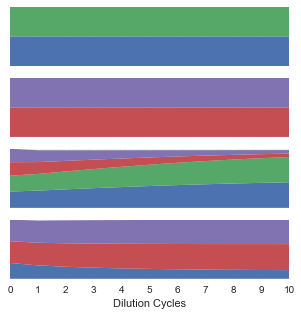

In [32]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt
%matplotlib inline
PlotTraj(Ntraj,figsize=(5,5))
plt.show()

The four panels represent the four wells. Each color is a species, and the thickness of the colored bar at each dilution cycle is proportional to the population of that species at the end of that cycle. 

The first two panels are controls, which simply propagate the two initial communities (which I will call 'A' and 'B'). The third panel shows the result of invading B with all of A, as can be seen by the presence of all four colors. The fourth is the invasion by the "champion" alone, which is the blue Enterobacter.

We can also visualize the final result in a bar plot with a legend, which may be easier to read:

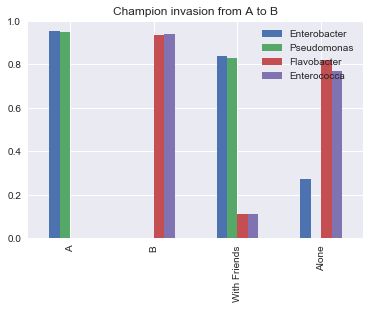

In [28]:
from community_simulator.visualization import StackPlot
import matplotlib.pyplot as plt
%matplotlib inline
MyPlate.N.T.plot.bar()
plt.gca().set_title('Champion invasion from A to B')
plt.gca().set_xticklabels(['A','B','With Friends','Alone'])
plt.show()

In this example (without crossfeeding), the champion does better when invading with his "friend" than he does alone. I contrived the example to have this result, by making the two species of community A almost perfect specialists, and those of B almost perfect generalists. If the consumer matrices for both communities had been drawn from the same probability distribution, it would have been very hard to achieve this result.